# Latent HGF: BA Project

In [42]:
import sys
from IPython.utils import io

In [43]:
# if 'google.colab' in sys.modules:

#   with io.capture_output() as captured:
#      ! pip install pyhgf watermark

In [70]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import jax

from pyhgf import load_data
from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF, Network
from pyhgf.response import first_level_gaussian_surprise
from pyhgf.utils import beliefs_propagation
# from pyhgf.updates.structure import add_parent


plt.rcParams["figure.constrained_layout.use"] = True

In [71]:
# Disable JIT compilation globally
jax.config.update("jax_disable_jit", False) # True - If I want the compiler disabled.

In [ ]:
timeserie = load_data("continuous")

latent_hgf = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, 
               value_children=0)
    .add_nodes(precision=1e1, tonic_volatility=-2.0, value_children=1)
    .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, 
               value_children=0)
    # .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=1)
    # .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, 
    #          value_children=2)
    # .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=2)
).create_belief_propagation_fn()

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\hesse\\miniconda3\\envs\\pymc_env\\Lib\\site-packages\\pyhgf\\data\\usdchf.txt'

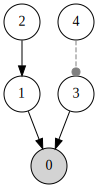

In [48]:
latent_hgf.plot_network()

In [ ]:
attributes, edges, update_sequence = (
    latent_hgf.get_network()
)

new_hgf_attributes, new_hgf_edges = add_parent(attributes, edges, 3, 'volatility')

In [ ]:
print(len(new_hgf_attributes))
print(len(new_hgf_edges))

7
6


In [ ]:
latent_hgf.attributes = new_hgf_attributes
latent_hgf.edges = new_hgf_edges

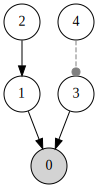

In [ ]:
latent_hgf.plot_network()

In [56]:
np.random.seed(123)
dist_mean, dist_std = 5, 1
input_data = np.random.normal(loc=dist_mean, scale=dist_std, size=1000)

In [76]:
# for each observation
for value in input_data:

    # interleave observations and masks
    data = (value, 1.0, 1.0)

    # update the probabilistic network
    attributes, _ = beliefs_propagation(
        attributes=attributes,
        inputs=data,
        update_sequence=update_sequence,
        edges=edges,
        input_idxs=latent_hgf.input_idxs
    )


In [77]:
attributes

{-1: {'time_step': Array(1., dtype=float32, weak_type=True)},
 0: {'autoconnection_strength': Array(0., dtype=float32, weak_type=True),
  'expected_mean': Array(5.1438637, dtype=float32),
  'expected_precision': Array(10000., dtype=float32, weak_type=True),
  'mean': Array(3.8885696, dtype=float32),
  'observed': Array(1., dtype=float32, weak_type=True),
  'precision': Array(10000., dtype=float32, weak_type=True),
  'temp': {'effective_precision': Array(0.9999, dtype=float32, weak_type=True),
   'value_prediction_error': Array(-0.62764704, dtype=float32),
   'volatility_prediction_error': Array(3939.408, dtype=float32)},
  'tonic_drift': Array(0., dtype=float32, weak_type=True),
  'tonic_volatility': Array(0., dtype=float32, weak_type=True),
  'value_coupling_children': None,
  'value_coupling_parents': (Array(1., dtype=float32, weak_type=True),
   Array(1., dtype=float32, weak_type=True)),
  'volatility_coupling_children': None,
  'volatility_coupling_parents': None},
 1: {'autoconnec